### **Finetuning and Joint Training**





**Install requirements**

In [ ]:
#!pip3 install 'torch==1.3.1'
#!pip3 install 'torchvision==0.5.0'
#!pip3 install 'Pillow-SIMD'
#!pip3 install 'tqdm'

**Import models and functions**

In [ ]:
import os

if not os.path.isdir('./models'):
  !git clone https://github.com/gabrieletiboni/Incremental-learning-on-image-recognition.git
  !cp -r "/content/Incremental-learning-on-image-recognition/CODE/utils" "/content/"
  !cp -r "/content/Incremental-learning-on-image-recognition/CODE/models" "/content/"

**Import libraries**

In [ ]:
import sys

import torch
import torch.nn as nn
from torch.backends import cudnn

import datetime
from pytz import timezone
import os
import math
import time

from torchvision.datasets import CIFAR100
from torchvision.transforms import transforms
import torchvision.utils
from torch.utils.data import Subset, DataLoader
import torch.optim as optim

from models.ResNet import resnet32
from utils.utils import *

import numpy as np
import matplotlib.pyplot as plt

**GLOBAL PARAMETERS**

In [ ]:
DEVICE = 'cuda'
NUM_CLASSES = 100
DATA_DIR = './CIFAR_100'
RUNS_DIR = '/content/Incremental-learning-on-image-recognition/RUNS'

# --- CUSTOM PARAMETERS
RANDOM_STATE = 2000          # int or None (Tarantino: 'tarantino', iCaRL: 1993, Telegram: 'telegram')

N_GROUPS_FOR_TRAINING = 10   # Numero di gruppi di classi da usare in fase di training (1: usa solo il primo gruppo, 10: usa tutti i gruppi di classi)

USE_BCE_LOSS = True

GITHUB_USER = 2             # 0: Roberto, 1: Alessandro, 2: Gabriele

CIFAR_NORMALIZE = True     # If True normalizes tensor with mean and standard deviation of CIFAR 100

DO_JOINT_TRAINING = True

METHOD = 'Joint_training_con_BCE_2000'
# ---------------------

DATA_AUGMENTATION = True
USE_VALIDATION_SET = False
SHUFFLE_CLASSES = True
DUMP_FINAL_RESULTS_ON_GSPREADSHEET = True
COMMIT_ON_GITHUB = True
EVAL_AFTER_EACH_EPOCH = False

# Force NO-BCE-LOSS when doing Joint Training
# if DO_JOINT_TRAINING:
#   USE_BCE_LOSS = False
# ----------------------------------

# --- HYPERPARAMETERS
BATCH_SIZE = 128
if USE_BCE_LOSS:
  LR = 2
else:
  LR = 0.2                  # iCaRL uses LR=2 solo perchè usa la BCE, in generale usare 0.2
MOMENTUM = 0.9              # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 1e-5         # Regularization

NUM_EPOCHS = 70             # Total number of training epochs (iterations over dataset)
DO_MULTILR_STEP_DOWN = True # step down at 7/10 and 9/10
STEP_SIZE = 10
GAMMA = 0.2                 # Multiplicative factor for learning rate step-down
# ---------------------

**Define Data Preprocessing**

In [ ]:
if CIFAR_NORMALIZE: 
  MEANS, STDS = (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762) # Normalizes tensor with mean and standard deviation of CIFAR 100
else: 
  MEANS, STDS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Define transforms for training phase
if DATA_AUGMENTATION:
  train_transform = transforms.Compose([
                                            transforms.RandomCrop(32, padding=4),
                                            transforms.RandomHorizontalFlip(p=0.5),
                                            transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                            transforms.Normalize(mean=MEANS, std=STDS) # Normalizes tensor with mean and standard deviation of CIFAR 100
                                        ])
else:
  train_transform = transforms.Compose([
                                        transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                        transforms.Normalize(mean=MEANS, std=STDS) # Normalizes tensor with mean and standard deviation of CIFAR 100
                                    ])

test_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=MEANS, std=STDS) # Normalizes tensor with mean and standard deviation of CIFAR 100                                                                                                
                                    ])

**Import dataset CIFAR-100**

In [ ]:
#For any information about CIFAR-100 follow the link below
#https://www.cs.toronto.edu/~kriz/cifar.html

train_dataset = CIFAR100(DATA_DIR, train=True, download=True, transform=train_transform)
test_dataset = CIFAR100(DATA_DIR, train=False, download=False, transform=test_transform)

if SHUFFLE_CLASSES:
  # --- Shuffle class ordering
  if RANDOM_STATE == 'telegram':
    classes_indexes = np.array([30,  4, 36, 47, 81, 65, 66, 64, 68, 23, 72, 48, 54, 73,  6, 50, 51,
                          83, 75, 88, 58, 62, 39, 60, 94, 25, 84, 37, 33, 76, 34, 57, 46,  3,
                          24, 67, 17, 79, 40, 77, 26, 27, 41, 90, 89, 59, 20, 11, 61, 13, 44,
                          56,  9, 96, 70, 99, 82, 78,  5, 53, 16, 29,  0, 31,  7, 74, 55, 19,
                          42,  1, 92, 63, 52, 69, 22, 18, 28, 35,  8, 91, 86, 32, 97, 98, 15,
                            2, 45, 49, 95, 71, 14, 87, 80, 21, 38, 93, 43, 10, 12, 85])
    
  elif RANDOM_STATE == 'tarantino':
    random.seed(653)
    classes_indexes = [i for i in range(NUM_CLASSES)]

    classes_indexes_cum = []
    remaining = [i for i in range(NUM_CLASSES)]
    for i in range(10):
      classes_indexes_cum += random.sample(remaining, 10)
      remaining = list(set(classes_indexes)-set(classes_indexes_cum))

    classes_indexes = classes_indexes_cum
    classes_indexes = np.array(classes_indexes)

    print('Tarantino classes order:', classes_indexes)

  else:
    if RANDOM_STATE is not None:
      np.random.seed(RANDOM_STATE)

    classes_indexes = np.array([i for i in range(NUM_CLASSES)])
    np.random.shuffle(classes_indexes)


  classes_shuffle_dict = {ind:i for i, ind in enumerate(classes_indexes)}

  train_dataset.targets = [classes_shuffle_dict[tar] for tar in train_dataset.targets]
  test_dataset.targets = [classes_shuffle_dict[tar] for tar in test_dataset.targets]

  CLASSES = train_dataset.classes
  train_dataset.class_to_idx = {CLASSES[i]:ind for i,ind in enumerate(classes_indexes)}
  LABEL_INDEX_DICT = train_dataset.class_to_idx
else:
  CLASSES = train_dataset.classes
  LABEL_INDEX_DICT = train_dataset.class_to_idx

# show_random_images(train_dataset, 5, mean=MEANS, std=STDS)

print('Train Dataset length:', len(train_dataset))
print('Test Dataset length:', len(test_dataset))

Files already downloaded and verified
Train Dataset length: 50000
Test Dataset length: 10000


**Prepare training**

In [ ]:
net = resnet32(num_classes=NUM_CLASSES)

# Define loss function
if USE_BCE_LOSS:
  criterion = nn.BCEWithLogitsLoss() # SUM is crucial as BCE is designed for one output neuron only (it averages on batch_size*num_classes instead of on just batch_size)
  criterion_eval = nn.BCEWithLogitsLoss()
else:
  criterion = nn.CrossEntropyLoss()
  criterion_eval = nn.CrossEntropyLoss(reduction='sum')

**Training**

******************************
NEW GROUP OF CLASSES 2°/10
Training set length: 10000
Test set length: 2000
Starting epoch 1/70, LR = [2]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:396: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


--- Initial loss on train: 0.7790983319282532
--- Epoch 1, Loss on train: 0.03287137299776077
Starting epoch 2/70, LR = [2]
--- Epoch 2, Loss on train: 0.02829813025891781
Starting epoch 3/70, LR = [2]
--- Epoch 3, Loss on train: 0.02677612192928791
Starting epoch 4/70, LR = [2]
--- Epoch 4, Loss on train: 0.025996526703238487
Starting epoch 5/70, LR = [2]
--- Epoch 5, Loss on train: 0.024525484070181847
Starting epoch 6/70, LR = [2]
--- Epoch 6, Loss on train: 0.02160685881972313
Starting epoch 7/70, LR = [2]
--- Epoch 7, Loss on train: 0.022990262135863304
Starting epoch 8/70, LR = [2]
--- Epoch 8, Loss on train: 0.023973576724529266
Starting epoch 9/70, LR = [2]
--- Epoch 9, Loss on train: 0.02121874690055847
Starting epoch 10/70, LR = [2]
--- Epoch 10, Loss on train: 0.02129797451198101
Starting epoch 11/70, LR = [2]
--- Epoch 11, Loss on train: 0.01933661848306656
Starting epoch 12/70, LR = [2]
--- Epoch 12, Loss on train: 0.017533449456095695
Starting epoch 13/70, LR = [2]
--- Ep

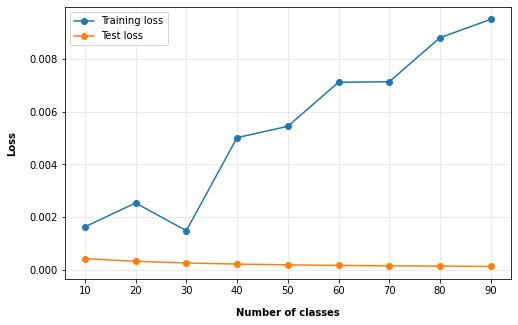

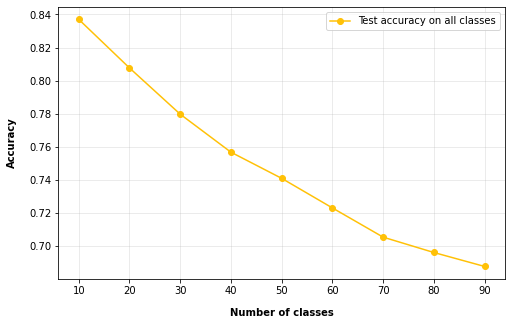

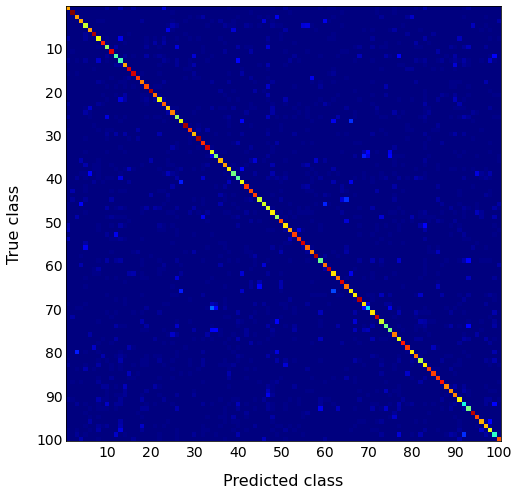

> In 308.2 minutes


In [ ]:
cudnn.benchmark # Calling this optimizes runtime

val_indexes_cum = []
test_indexes_cum = []
current_classes_cum = []

group_losses_train = []
group_losses_eval = []
group_accuracies_train = []
group_accuracies_eval = []
group_accuracies_eval_curr = []

now = datetime.datetime.now(timezone('Europe/Rome'))
CURRENT_RUN = 'RUN_' + now.strftime("%Y-%m-%d %H %M %S")
try:
  os.makedirs(RUNS_DIR+'/'+CURRENT_RUN)
except OSError:
  print ("FATAL ERROR - Creation of the directory of the current run failed")
  sys.exit()

dump_hyperparameters(path=RUNS_DIR+'/'+CURRENT_RUN, lr=LR, weight_decay=WEIGHT_DECAY, num_epochs=NUM_EPOCHS, method=METHOD, batch_size=BATCH_SIZE)

START_TIME = time.time()

for group_number in range(1, N_GROUPS_FOR_TRAINING):

  if DO_JOINT_TRAINING:
    net = resnet32(num_classes=NUM_CLASSES)
    starting_label = 0
  else:
    starting_label = (group_number*10)

  ending_label = (group_number+1)*10
  current_classes = list(range(starting_label, ending_label))

  new_indexes = get_indexes_from_labels(train_dataset, current_classes)

  if USE_VALIDATION_SET:
    new_train_indexes, new_val_indexes = train_validation_split(train_dataset, new_indexes, train_size=0.9, random_state=RANDOM_STATE)

    train_dataset_curr = Subset(train_dataset, new_train_indexes)
    val_dataset_cum = Subset(train_dataset, val_indexes_cum+new_val_indexes)
    val_dataset_curr = Subset(train_dataset, new_val_indexes)

    val_dataloader = DataLoader(val_dataset_cum, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    val_dataloader_curr = DataLoader(val_dataset_curr, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    val_indexes_cum += new_val_indexes

  else:
    train_dataset_curr = Subset(train_dataset, new_indexes)

  # Update training set
  train_dataloader = DataLoader(train_dataset_curr, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
  train_dataloader_for_evaluation = DataLoader(train_dataset_curr, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

  # Update test set
  new_test_indexes = get_indexes_from_labels(test_dataset, current_classes)
  test_dataset_cum = Subset(test_dataset, test_indexes_cum+new_test_indexes)
  test_dataset_curr = Subset(test_dataset, new_test_indexes)
  if DO_JOINT_TRAINING == False:
    test_indexes_cum += new_test_indexes

  test_dataloader = DataLoader(test_dataset_cum, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
  test_dataloader_curr = DataLoader(test_dataset_curr, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

  print('******************************')
  print(f'NEW GROUP OF CLASSES {(group_number+1)}°/{N_GROUPS_FOR_TRAINING}')
  print('Training set length:', len(train_dataset_curr))
  if USE_VALIDATION_SET:
    print('Validation set length:', len(val_dataset_cum))
  print('Test set length:', len(test_dataset_cum))
  
  net = net.to(DEVICE)

  parameters_to_optimize = net.parameters()

  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  if DO_MULTILR_STEP_DOWN:
    milestone_1 = math.floor(NUM_EPOCHS/10*7)
    milestone_2 = math.floor(NUM_EPOCHS/10*9)

    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[milestone_1, milestone_2], gamma=GAMMA)
  else:
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  current_step = 0
  losses_train = []
  losses_eval = []
  accuracies_train = []
  accuracies_eval = []
  accuracies_eval_curr = []

  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

    # Iterate over the dataset
    for images, labels in train_dataloader:
      # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train() # Sets module in training mode

      optimizer.zero_grad() # Zero-ing the gradients

      # Forward pass to the network
      outputs = net(images)

      if USE_BCE_LOSS:
        targets_bce = torch.zeros([BATCH_SIZE, 100], dtype=torch.float32)

        for i in range(BATCH_SIZE):
          targets_bce[i][labels[i]] = 1

        targets_bce = targets_bce.to(DEVICE)

        loss = criterion(outputs[:, 0:100], targets_bce)

      else:
        loss = criterion(outputs[:, 0:ending_label], labels)
      
      if current_step == 0:
        print('--- Initial loss on train: {}'.format(loss.item()))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients

      current_step += 1

    # --- END OF CURRENT EPOCH 
    scheduler.step()

    print('--- Epoch {}, Loss on train: {}'.format(epoch+1, loss.item()))
    losses_train.append(loss.item())


  # --- END OF TRAINING FOR THIS GROUP OF CLASSES
  if EVAL_AFTER_EACH_EPOCH == False: # Do it at least at the end of each group
    
    if USE_VALIDATION_SET:
      with torch.no_grad():
        loss_val, accuracy_val = eval_model(net, val_dataloader, criterion=criterion_eval,
                                            dataset_length=len(val_dataset_cum), use_bce_loss=USE_BCE_LOSS,
                                            ending_label=ending_label, device=DEVICE, display=True, suffix=' (group)')

      losses_eval.append(loss_val)
      accuracies_eval.append(accuracy_val)
    else:
      with torch.no_grad():
        loss_test, accuracy_test = eval_model(net, test_dataloader, criterion=criterion_eval,
                                              dataset_length=len(test_dataset_cum), use_bce_loss=USE_BCE_LOSS,
                                              ending_label=ending_label, device=DEVICE, display=True, suffix=' (group)')

      losses_eval.append(loss_test)
      accuracies_eval.append(accuracy_test)

  # --- Accuracy on training
  with torch.no_grad():
    accuracy_train = eval_model_accuracy(net, train_dataloader_for_evaluation, dataset_length=len(train_dataset_curr), starting_label=starting_label, ending_label=ending_label, device=DEVICE, display=True, suffix='train (group)')
  
  accuracies_train.append(accuracy_train)
  # ------------------------

  # --- Compute accuracy on test for novel classes only
  if DO_JOINT_TRAINING == False:
    with torch.no_grad():
      accuracy_eval_curr_classes = eval_model_accuracy(net, test_dataloader_curr, dataset_length=len(test_dataset_curr), starting_label=starting_label, ending_label=ending_label, device=DEVICE, display=True, suffix='test novel classes (group)')
    accuracies_eval_curr.append(accuracy_eval_curr_classes)
  # ---------------------------------------------------

  path = RUNS_DIR+'/'+CURRENT_RUN    
  create_dir_for_current_group(group_number, path=path)
  
  draw_graphs(losses_train,
        losses_eval,
        accuracies_train,
        accuracies_eval,
        num_epochs=NUM_EPOCHS, use_validation=USE_VALIDATION_SET, print_img=False, save=True, path=path, group_number=group_number)
  
  dump_to_csv(losses_train,
        losses_eval,
        accuracies_train,
        accuracies_eval,
        group_number=group_number, path=path)

  group_losses_train.append(losses_train[-1])
  group_losses_eval.append(losses_eval[-1])
  group_accuracies_train.append(accuracies_train[-1])
  group_accuracies_eval.append(accuracies_eval[-1])
  if DO_JOINT_TRAINING == False:
    group_accuracies_eval_curr.append(accuracies_eval_curr[-1])

# END OF OVERALL TRAINING
dump_final_values(group_losses_train, group_losses_eval, group_accuracies_train, group_accuracies_eval, group_accuracies_eval_curr, path=RUNS_DIR+'/'+CURRENT_RUN)
draw_final_graphs(group_losses_train, group_losses_eval, group_accuracies_eval_curr, group_accuracies_eval, DO_JOINT_TRAINING, use_validation=USE_VALIDATION_SET, print_img=True, save=True, path=RUNS_DIR+'/'+CURRENT_RUN)

# --- Compute and display confusion matrix
if USE_VALIDATION_SET:
  conf_mat = get_conf_matrix(net, val_dataloader, ending_label=ending_label, device=DEVICE)
else:
  conf_mat = get_conf_matrix(net, test_dataloader, ending_label=ending_label, device=DEVICE)
display_conf_matrix(conf_mat, display=True, save=True, path=RUNS_DIR+'/'+CURRENT_RUN)
# --- 

DURATION = round((time.time()-START_TIME)/60, 1)
print(f"> In {(DURATION)} minutes")

#todo: github commit of local directories
#todo: hyperparameters string in dump_on_gspreadsheet
github_link = 'https://github.com/gabrieletiboni/Incremental-learning-on-image-recognition/tree/master/RUNS/'+str(CURRENT_RUN)
github_link = github_link.replace(" ", "%20")
hyperparameters_string = get_hyperparameter_string(lr=LR, weight_decay=WEIGHT_DECAY, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, multilrstep=DO_MULTILR_STEP_DOWN, gamma=GAMMA)
if DUMP_FINAL_RESULTS_ON_GSPREADSHEET:
  dump_on_gspreadsheet(CURRENT_RUN, GITHUB_USER, github_link, METHOD, RANDOM_STATE, DO_JOINT_TRAINING, USE_BCE_LOSS, CIFAR_NORMALIZE, group_losses_train, group_losses_eval, group_accuracies_train, group_accuracies_eval, group_accuracies_eval_curr, DURATION, use_validation=USE_VALIDATION_SET, hyperparameters=hyperparameters_string)

# audio signal END
beep()